In [2]:
'''                                  ReadMe                                                      '''
'''# Nessa célula vamos apenas mudar a função geradora do estado a ser preparado                 '''
'''# Basta alterar a função que gera o estado, nesse caso target_op = init_state_ref(n_qubits, p)'''

from src.vqa_tools import general_vqacircuit_penny 
from src.state_initializer import  init_state_ref,init_state_bpf
from src.generalize import *
from torch import tensor
from numpy import sin,cos,sqrt,outer,zeros, pi
import cmath
import pickle

def state_bit_flip(theta, phi, p):
    state = zeros(4,dtype=complex)    
    state[0] = sqrt(p)*cos(theta/2)
    state[1] = sqrt(1-p)*cos(theta/2)
    state[2] = sqrt(p)*cmath.exp(1j*phi)*sin(theta/2)
    state[3] = sqrt(1-p)*cmath.exp(1j*phi)*sin(theta/2)
    target_op = outer(state.conj(), state)
    target_op = tensor(target_op)
    return target_op


def run_calcs(list_p, epochs):
    coerencias_R = []
    coerencias_L = []
    pretrain = True
    count = 0
    n_qubits = 2
    depht = 3
    _, params, _, _ = start_things(n_qubits, depht)
    for p in list_p:
        print(f'{count} de {len(list_p)}')
        count += 1

        circuit, _ = general_vqacircuit_penny(n_qubits, depht)

        #_, target_op = init_state_ref(n_qubits, p)
        #_, target_op = init_state_bpf(n_qubits, p)
        #target_op = state_amplitude_damping(pi/2, 0, p)
        #target_op = state_generalized_amplitude_damping(pi/2, 0, p,1)
        target_op = state_bit_flip(pi/2, 0, p)
        pretrain = False
        qc, qr, params = optmize(epochs, n_qubits, circuit, params, target_op, pretrain)
        rho = tomograph(qc, qr)
        #print(rho)
        coerencias_L, coerencias_R = results(rho, coerencias_R, coerencias_L)

    plots(list_p, coerencias_R, coerencias_L)
    print(type(params))
    with open('best_params_bf.pkl', 'wb') as f:
        pickle.dump(params, f)

0 de 5
1 de 5
2 de 5
3 de 5
4 de 5


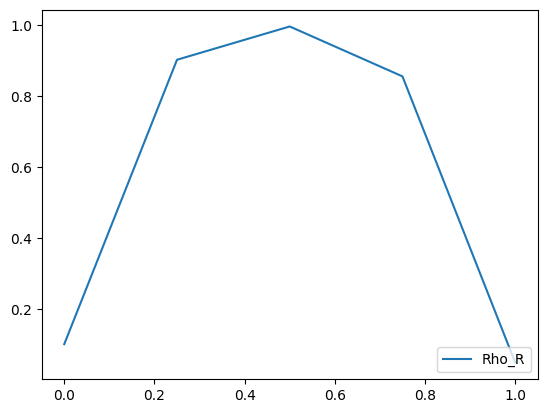

<class 'torch.Tensor'>


In [3]:
from numpy import linspace
list_p = linspace(0,1,5)
#print(list_p)
run_calcs(list_p, 50)

In [1]:
from numpy import linspace
list_p = linspace(0,1,5)
print(list_p)

[0.   0.25 0.5  0.75 1.  ]


# Abaixo é rodando no quantico com job docker

In [ ]:
from pennylane_qiskit import upload_vqe_runner, vqe_runner
import pennylane as qml
from qiskit import IBMQ
#IBMQ.enable_account(token)

program_id = upload_vqe_runner(hub="ibm-q", group="open", project="main")
print(program_id)
def vqe_circuit(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
shots = 10

coeffs = [1, 1]
obs = [qml.PauliX(0), qml.PauliZ(0)]
hamiltonian = qml.Hamiltonian(coeffs, obs)

job = vqe_runner(
    program_id=program_id,
    backend="ibmq_manila",
    hamiltonian=hamiltonian,
    ansatz=vqe_circuit,
    x0=[3.97507603, 3.00854038],
    shots=shots,
    optimizer="SPSA",
    optimizer_config={"maxiter": 40},
    kwargs={"hub": "ibm-q", "group": "open", "project": "main"},
)